**Projeto Análise de Dados**


*Este bloco de notas contém todo o código usado para processamento da modelagem dos dados agrupados para criação e testes de um modelo de classificação*

Este bloco de notas recebe como entrada o arquivo construído e fornecido pelo bloco de notas usado para análise exploratória e agrupamento (*clustering*) dos bairros e suas atividades.
O arquivo de entrada contém uma tabela cujas linhas contêm os bairros presentes no arquivo ATIVECO_ES (mapeadas para os códigos de bairros do IBGE) e cuja coluna `pred` contêm a identificação do cluster ao qual cada bairro pertence.

Para a modelagem são utilizados modelos de classificação multiclasse denominados classificadores multiclasses (também chamados classificadores multinomiais). Para análises e comparações foram utilizados os classificadores Stochastic Gradiente Descendente (*Stochastic Gradient Descent* - SGD), $k$-vizinhos mais pŕoximos (*$k$-Nearest Neighbors* - KNN), Florestas Aleatórias (*Random Forest* - RF) e Máquinas de Vetores de Suporte (*Suport Vector Machine* - SVM).

Os modelos foram treinados e avaliados utilizanado o recurso da validação cruzada do Scikit-Learn. Os hiperparâmetros dos modelos foram ajustados utilizanado o recurso de *Grid Search* combinado com validação cruzada do Scikit-Learn.

# Setup

Primeiro, vamos importar alguns módulos comuns, garantir que o MatplotLib plote figuras em linha e preparar uma função para salvar as figuras. Também verificamos se o Python 3.5 ou posterior está instalado (embora o Python 2.x possa funcionar, ele está obsoleto, por isso recomendamos fortemente que seja usado o Python 3), bem como o Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#CHAPTER_ID = "AnaliseExploratoria"
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "OUTPUT","images", CHAPTER_ID)
#os.makedirs(IMAGES_PATH, exist_ok=True)

DATA_PATH_INPUT= os.path.join(".", "INPUT")
DATA_PATH_OUTPUT = os.path.join(".","OUTPUT")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    DATA_PATH_OUTPUT_IMAGE = os.path.join("OUTPUT", "Imagens")
    if not os.path.isdir(DATA_PATH_OUTPUT_IMAGE):
        os.makedirs(DATA_PATH_OUTPUT_IMAGE)
    path = os.path.join(DATA_PATH_OUTPUT, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Carregando os dados do arquivos físicos

In [2]:
import pandas as pd

def load_cluster3(data_path=DATA_PATH_INPUT):
    csv_path = os.path.join(data_path, "504_PCA_Cluster3.csv")
    return pd.read_csv(csv_path)
    ### Drop index while reading a CSV
    # return pd.read_csv(csv_path, index_col=False)

def load_data_SocioEconomico(data_path=DATA_PATH_INPUT):
    csv_path = os.path.join(data_path, "TabelaIBGE_Socio_Economica.csv")
    return pd.read_csv(csv_path)


# Preparação dos dados Sócio-Econômicos

In [3]:
### Leitura da base de dados com informações sócio-econômicas
### Cada linha um bairro e cada característica  sócio-econômica nas colunas
Socio_Economica = load_data_SocioEconomico()
Socio_Economica.head()

,Cód.,Bairro,Domicílios - Total,Domicílios - 1 morador,Domicílios - casa,Domicílios - apartamento,Domicílios ocupação - Próprio,Domicílios ocupação- alugado,Rede geral de esgoto ou pluvial,Lixo Coletado,...,Residentes – Homens,Residentes – Mulheres,Residentes – 0 a 9 anos,Residentes – 10 a 19 anos,Residentes – 20 a 29 anos,Residentes – 30 a 39 anos,Residentes – 40 a 49 anos,Residentes – 50 a 59 anos,Residentes – 60 a 69 anos,Residentes – 70 ou mais
0,3201308001,Cruzeiro do Sul - Cariacica,1431,201,1099,329,962,416,1412,1427,...,1997,2221,482,656,697,689,683,502,289,220
1,3201308002,Vasco da Gama - Cariacica,392,58,372,20,296,95,320,390,...,526,632,145,154,214,197,155,140,76,77
2,3201308003,São Francisco - Cariacica,2162,311,1421,729,1576,503,2083,2162,...,3078,3356,883,1032,1272,1098,933,695,330,191
3,3201308004,Vila Palestina - Cariacica,1007,144,761,232,610,318,1002,1007,...,1435,1531,307,412,614,517,439,338,212,127
4,3201308005,Rosa da Penha - Cariacica,1230,133,1093,106,895,280,1216,1227,...,1820,1992,495,579,696,702,529,405,252,154


In [4]:
Socio_Economica.shape

(406, 35)

In [5]:
Socio_Economica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 35 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   Cód.                                              406 non-null    int64 
 1   Bairro                                            406 non-null    object
 2   Domicílios - Total                                406 non-null    object
 3   Domicílios - 1 morador                            406 non-null    object
 4   Domicílios - casa                                 406 non-null    object
 5   Domicílios - apartamento                          406 non-null    object
 6   Domicílios ocupação - Próprio                     406 non-null    object
 7   Domicílios ocupação- alugado                      406 non-null    object
 8   Rede geral de esgoto ou pluvial                   406 non-null    object
 9   Lixo Coletado                   

In [6]:
csv_path = os.path.join(DATA_PATH_OUTPUT, "001Socio_Economica.csv")
Socio_Economica.to_csv(csv_path, index=True, header=True)
print("001", Socio_Economica.shape)

001 (406, 35)


In [7]:
### Substituir caracter "-" por zero. IBGE apresenta "vazio" = "-".
## Como todos os campos são numéricos, "vazio" = 0 para nós
Socio_Economica = Socio_Economica.replace('-',0)

### do arquivo sintese-indicadores-sociais-ibge-2022.pdf
#Convenções
# -               Dado numérico igual a zero não resultante de arredondamento;
# ..              Não se aplica dado numérico;
# ...             Dado numérico não disponível;
# X               Dado numérico omitido a fim de evitar a individualização da informação;
# 0; 0,0; 0,00    Dado numérico igual a zero resultante de arredondamento de um dado numérico originalmente positivo; e
# -0; -0,0; -0,00 Dado numérico igual a zero resultante de arredondamento de um dado numérico originalmente negativo.


### Remover linhas com colunas com 'X' (Dado numérico omitido a fim de evitar a individualização da informação).
## 3201308060 - Porto das Pedras - Cariacica (população total = 10)
## 3201308062 - Porto Engenho - Cariacica (população total = 8)
## 3205002059 - Terminal Intermodal da Serra - Serra (ES) (população total = 1)

#df = df[~(df == '?').any(axis=1)]
Socio_Economica_Clean = Socio_Economica[(Socio_Economica != 'X').all(axis=1)]
Socio_Economica_Clean.reset_index(inplace=True,drop=True)
csv_path = os.path.join(DATA_PATH_OUTPUT, "002Socio_Economica_Clean.csv")
Socio_Economica_Clean.to_csv(csv_path, index=True, header=True)
print("002", Socio_Economica_Clean.shape)


002 (403, 35)


In [8]:
#Socio_Economica_Clean.loc["Cód."] = Socio_Economica_Clean.loc["Cód."].astype(str)
Socio_Economica_Clean = Socio_Economica_Clean.astype({'Domicílios - Total':'int'})
cols = Socio_Economica_Clean.columns.drop(['Cód.','Bairro'])
Socio_Economica_Clean[cols] = Socio_Economica_Clean[cols].apply(pd.to_numeric, errors='coerce')




In [9]:
Socio_Economica_Clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 35 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Cód.                                              403 non-null    int64  
 1   Bairro                                            403 non-null    object 
 2   Domicílios - Total                                403 non-null    int64  
 3   Domicílios - 1 morador                            403 non-null    int64  
 4   Domicílios - casa                                 403 non-null    int64  
 5   Domicílios - apartamento                          403 non-null    int64  
 6   Domicílios ocupação - Próprio                     403 non-null    int64  
 7   Domicílios ocupação- alugado                      403 non-null    int64  
 8   Rede geral de esgoto ou pluvial                   403 non-null    int64  
 9   Lixo Coletado        

# Criação base de dados para modelagem
- Inserir o número do cluster calculado pelo K-means na base socio-economica (merge)
- Em seguida, separar a base socio-economica em treinamento e teste

In [10]:
### Leitura da base de dados com informações sócio-econômicas
### Cada linha um bairro e cada característica  sócio-econômica nas colunas
PCA_Cluster3 = load_cluster3()
#PCA_Cluster3.head()

csv_path = os.path.join(DATA_PATH_OUTPUT, "003PCA_Cluster3.csv")
PCA_Cluster3.to_csv(csv_path, index=True, header=True)
print("003", PCA_Cluster3.shape)

003 (386, 4)


In [11]:
Socio_Economica_Cluster3 = pd.merge(PCA_Cluster3[["Cód.","pred"]], Socio_Economica_Clean, left_on = 'Cód.', right_on = 'Cód.')

csv_path = os.path.join(DATA_PATH_OUTPUT, "100Socio_Economica_Cluster3.csv")
Socio_Economica_Cluster3.to_csv(csv_path, index=True, header=True)
print("100", Socio_Economica_Cluster3.shape)


Socio_Economica_Cluster3["pred"].value_counts()


100 (383, 36)


2    297
0     74
1     12
Name: pred, dtype: int64

# Criando um conjunto de teste estratificado

### Amostragem estratificada com base na categoria "pred"
Na amostragem estratificada a população é dividida em subgrupos homogêneos, chamados de estratos, e o número certo de instâncias de cada estrato é amostrado para garantir que o conjunto de testes seja representativo da população em geral.

Por exemplo, a população dos EUA é composta por 51,3% de pessoas do sexo feminino e 48,7% do sexo masculino, de modo que uma pesquisa bem conduzida tentaria manter essa proporção na amostragem: 513 mulheres e 487 homens.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

### Cria dois conjuntos: treinamento e teste divididos percentualmente em test_ratio
def split_stratified_train_test_by_id(data, test_ratio, id_column, random_stat):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_stat)
    for train_index, test_index in split.split(data, data[id_column]):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return train_set,test_set


### Cria três conjuntos: treinamento, validação e teste
# divididos percentualmente em tune_ratio e test_ratio, respectivamente
def split_stratified_train_tune_test_by_id(data, tune_ratio, test_ratio, id_column, random_stat):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_stat)
    for train_index, test_valid_index in split.split(data, Socio_Economica_Cluster3.pred):
        train_set = data.iloc[train_index]
        test_valid_set = data.iloc[test_valid_index]

    split2 = StratifiedShuffleSplit(n_splits=1, test_size=tune_ratio, random_state=42)
    for test_index, valid_index in split2.split(test_valid_set, test_valid_set.pred):
        test_set = test_valid_set.iloc[test_index]
        valid_set = test_valid_set.iloc[valid_index]
    return train_set,tune_set, test_set            
            
            

In [13]:
strat_train_set, strat_test_set = split_stratified_train_test_by_id(Socio_Economica_Cluster3, 0.2, "pred", 0)


In [14]:
print(strat_train_set["pred"].value_counts())
strat_train_set["pred"].value_counts() / len(strat_train_set)

2    237
0     59
1     10
Name: pred, dtype: int64


2    0.77451
0    0.19281
1    0.03268
Name: pred, dtype: float64

In [15]:
print(strat_test_set["pred"].value_counts())
strat_test_set["pred"].value_counts() / len(strat_test_set)

2    60
0    15
1     2
Name: pred, dtype: int64


2    0.779221
0    0.194805
1    0.025974
Name: pred, dtype: float64

# Dimensionando os conjuntos de treinamento e teste

os algoritmos de Aprendizado de Máquina não funcionam bem quando atributos numéricos de entrada têm escalas muito diferentes.

In [16]:
SE_train_set = strat_train_set.drop(["Cód.","Bairro","pred"], axis=1) # drop labels for training set
SE_train_set_labels = strat_train_set["pred"].copy()

In [17]:
SE_train_set

,Domicílios - Total,Domicílios - 1 morador,Domicílios - casa,Domicílios - apartamento,Domicílios ocupação - Próprio,Domicílios ocupação- alugado,Rede geral de esgoto ou pluvial,Lixo Coletado,Média de moradores domicílios,Residente – Total,...,Residentes – Homens,Residentes – Mulheres,Residentes – 0 a 9 anos,Residentes – 10 a 19 anos,Residentes – 20 a 29 anos,Residentes – 30 a 39 anos,Residentes – 40 a 49 anos,Residentes – 50 a 59 anos,Residentes – 60 a 69 anos,Residentes – 70 ou mais
268,2521,294,2144,368,1753,568,1573,2519,3.17,8003,...,3849,4154,1073,1296,1415,1250,1204,878,464,423
275,2525,335,2423,71,1822,507,2146,2524,3.09,7822,...,3750,4072,1059,1249,1372,1298,1155,798,506,385
226,3982,632,933,2990,2639,1172,3176,3960,2.91,11648,...,5705,5943,1304,1693,1986,2049,1990,1492,693,441
296,1031,129,997,33,771,214,137,1030,3.33,3445,...,1730,1715,575,667,633,595,471,320,120,64
198,2161,202,2134,25,1727,309,1460,1866,3.32,7175,...,3519,3656,1152,1221,1471,1172,886,689,347,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,643,72,643,0,499,110,431,619,3.59,2307,...,1159,1148,472,470,408,399,241,173,89,55
95,865,81,862,3,647,167,26,865,3.41,2952,...,1431,1521,451,591,498,510,400,271,137,94
229,390,55,340,42,231,127,389,390,3.07,1199,...,611,588,161,195,284,185,177,131,37,29
216,2224,279,1591,614,1491,585,2062,2218,3.07,6835,...,3261,3574,839,1127,1263,1098,992,769,417,330


In [18]:
### Standardization: first it subtracts the mean value (so standardized values always have a zero mean),
### and then it divides by the standard deviation so that the resulting distribution has unit variance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
SE_train_set_Scaler = scaler.fit_transform(SE_train_set)

### Min-max scaling (many people call this normalization) is quite simple:
### values are shifted and rescaled so that they end up ranging from 0 to 1.
### neural networks often expect an input value ranging from 0 to 1
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#SE_train_set_Scaler = scaler.fit_transform(SE_train_set)


In [19]:
SE_train_set_Scaler

array([[ 0.8284662 ,  0.56992695,  1.27338126, ...,  0.84648661,
         0.89069909,  1.16352612],
       [ 0.83113067,  0.74515372,  1.583233  , ...,  0.69974692,
         1.04011778,  0.99358978],
       [ 1.80166256,  2.01447935, -0.07153077, ...,  1.97271374,
         1.70538672,  1.24402228],
       ...,
       [-0.59102828, -0.4515169 , -0.73010454, ..., -0.52369525,
        -0.62839093, -0.59844541],
       [ 0.63062957,  0.5058196 ,  0.65923068, ...,  0.64655378,
         0.72349246,  0.74762929],
       [ 0.90107291,  0.70241549,  1.46440097, ...,  1.28853993,
         1.64490772,  1.32899045]])

In [20]:
X_train = SE_train_set_Scaler
y_train = SE_train_set_labels.to_numpy()

In [21]:
X_train

array([[ 0.8284662 ,  0.56992695,  1.27338126, ...,  0.84648661,
         0.89069909,  1.16352612],
       [ 0.83113067,  0.74515372,  1.583233  , ...,  0.69974692,
         1.04011778,  0.99358978],
       [ 1.80166256,  2.01447935, -0.07153077, ...,  1.97271374,
         1.70538672,  1.24402228],
       ...,
       [-0.59102828, -0.4515169 , -0.73010454, ..., -0.52369525,
        -0.62839093, -0.59844541],
       [ 0.63062957,  0.5058196 ,  0.65923068, ...,  0.64655378,
         0.72349246,  0.74762929],
       [ 0.90107291,  0.70241549,  1.46440097, ...,  1.28853993,
         1.64490772,  1.32899045]])

In [22]:
y_train

array([0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0,

In [23]:
SE_test_set = strat_test_set.drop(["Cód.","Bairro","pred"], axis=1) 
SE_test_set_Scaler = scaler.fit_transform(SE_test_set)
SE_test_set_labels = strat_test_set["pred"].copy()

In [24]:
X_test = SE_test_set_Scaler
y_test = SE_test_set_labels.to_numpy()

In [25]:
X_test

array([[ 3.09790879,  3.08884476, -0.85743424, ...,  3.13857185,
         2.54242495,  1.99697568],
       [-0.775918  , -0.68945671, -0.94150012, ..., -0.70185099,
        -0.71619884, -0.66368766],
       [ 0.09571291, -0.01764642,  0.23218897, ...,  0.14801293,
         0.33439571,  0.25522276],
       ...,
       [-0.0259655 , -0.04795365,  0.04304073, ...,  0.17206569,
        -0.08584211, -0.07474962],
       [-0.42758375, -0.35607716, -0.23179005, ..., -0.43125753,
        -0.40636248, -0.47990557],
       [-0.37032333, -0.44194765, -0.11700779, ..., -0.35308608,
        -0.36718777, -0.3796608 ]])

In [26]:
y_test

array([0, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0,
       2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Classificação Multiclasse

Enquanto classificadores binários se distinguem entre duas classes os classificadores multiclasses (também chamados classificadores multinomiais) podem distinguir entre mais de duas classes.

Alguns algoritmos (como os classificadores de Floresta Aleatória ou classificadores Naive-Bayes) são capazes de lidar diretamente com múltiplas classes. Outros (como os classificadores Máquinas de Vetores de Suporte ou classificadores Lineares) são estritamente binários. Entretanto, existem várias estratégias que você pode utilizar para realizar a classificação multiclasse com classificadores binários múltiplos.

## Procedimento para rodar testes

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score

def Run_Model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    model.predict(X_test)
    cross_val_scr = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    
    tree_rmse_scores = np.sqrt(-scores)
    
    f1_scr_macro = f1_score(y_train, y_train_pred, average="macro")
    f1_scr_weighted = f1_score(y_train, y_train_pred, average="weighted") #F-Mesure
    conf_mx = confusion_matrix(y_train, y_train_pred)
    print(confusion_matrix(y_train, y_train_pred))
    
    print(cohen_kappa_score(y_train, y_train_pred)) #1 means perfect agreement
    
    return cross_val_scr,f1_scr_macro, f1_scr_weighted,conf_mx, tree_rmse_scores


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Stochastic Gradient Descent (SGD) classifier

[[ 41   2  16]
 [  3   7   0]
 [ 23   0 214]]
0.6162243821794031
[0.89215686 0.85294118 0.82352941]
0.7680413262516271
0.8593887425781052
Scores: [0.62217102 0.47519096 0.71842121 0.87988269 0.80321933 0.53881591
 0.63245553 0.96609178 0.73029674 0.83666003]
Mean: 0.7203205198355057
Standard deviation: 0.14722765743062272


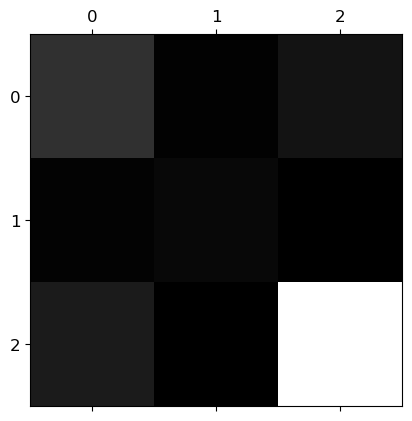

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
cross_val_scr,f1_scr_macro, f1_scr_weighted,conf_mx,tree_rmse_scores = Run_Model(sgd_clf, X_train, y_train, X_test, y_test)
print(cross_val_scr)
print(f1_scr_macro)
print(f1_scr_weighted)

display_scores(tree_rmse_scores)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

## k-Nearest Neighbors Classifier

[[ 41   2  16]
 [  3   7   0]
 [ 23   0 214]]
0.6162243821794031
[0.89215686 0.85294118 0.82352941]
0.7680413262516271
0.8593887425781052
Scores: [0.62217102 0.47519096 0.71842121 0.87988269 0.80321933 0.53881591
 0.63245553 0.96609178 0.73029674 0.83666003]
Mean: 0.7203205198355057
Standard deviation: 0.14722765743062272


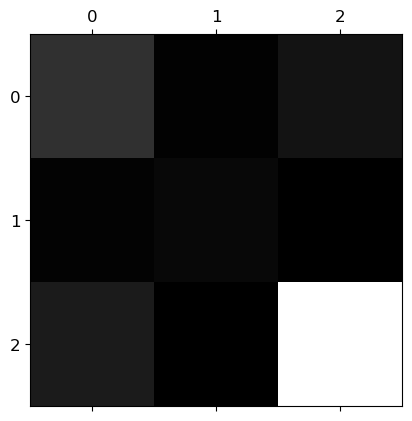

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
cross_val_scr,f1_scr_macro, f1_scr_weighted,conf_mx,tree_rmse_scores = Run_Model(sgd_clf, X_train, y_train, X_test, y_test)
print(cross_val_scr)
print(f1_scr_macro)
print(f1_scr_weighted)

display_scores(tree_rmse_scores)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


## Random Forest Classifier

[[ 43   1  15]
 [  4   6   0]
 [ 12   0 225]]
0.7051046529137177
[0.88235294 0.91176471 0.89215686]
0.792697379559435
0.8942605529078077
Scores: [0.50800051 0.43994135 0.95038193 0.50800051 0.50800051 0.53881591
 0.51639778 0.81649658 0.51639778 0.65828059]
Mean: 0.5960713430290407
Standard deviation: 0.15543911866371832


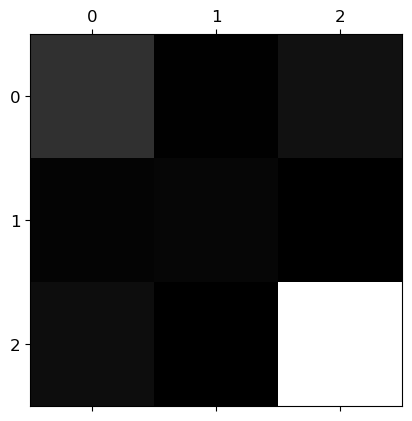

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
#forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

cross_val_scr,f1_scr_macro, f1_scr_weighted,conf_mx,tree_rmse_scores = Run_Model(forest_clf, X_train, y_train, X_test, y_test)
print(cross_val_scr)
print(f1_scr_macro)
print(f1_scr_weighted)

display_scores(tree_rmse_scores)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


## Suport Vector Machine

[[ 39   1  19]
 [  4   6   0]
 [ 16   0 221]]
0.6313808161421472
[0.8627451  0.89215686 0.85294118]
0.7645080133464038
0.8681989752369069
Scores: [0.64757613 0.67202151 0.87988269 0.50800051 0.71842121 0.64757613
 0.63245553 0.91287093 0.51639778 0.65828059]
Mean: 0.6793482992181353
Standard deviation: 0.12526048628636127


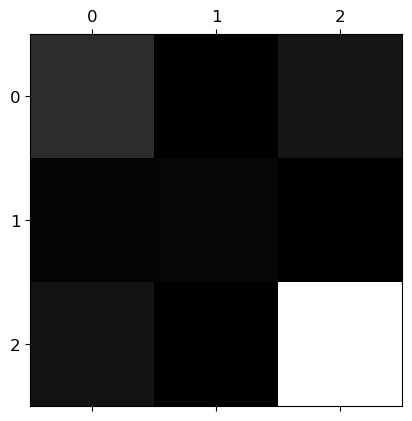

In [31]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#svm_clf = LinearSVC(C=1, loss="hinge")
#svm_clf = SVC()

#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

svm_clf = SVC(kernel='linear', C=1, decision_function_shape='ovo')

cross_val_scr,f1_scr_macro, f1_scr_weighted,conf_mx,tree_rmse_scores = Run_Model(svm_clf, X_train, y_train, X_test, y_test)
print(cross_val_scr)
print(f1_scr_macro)
print(f1_scr_weighted)

display_scores(tree_rmse_scores)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Ajustes de hiperParâmetros


### Grid Search

In [32]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier


param_grid = [
{'n_estimators': [30, 100], 'max_features': [10, 12, 20]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]


forest_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(forest_clf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [10, 12, 20],
                          'n_estimators': [30, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [33]:
grid_search.best_params_

{'max_features': 10, 'n_estimators': 30}

In [34]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.5861074526571775 {'max_features': 10, 'n_estimators': 30}
0.5942612921452541 {'max_features': 10, 'n_estimators': 100}
0.6053699412197608 {'max_features': 12, 'n_estimators': 30}
0.5944392413309001 {'max_features': 12, 'n_estimators': 100}
0.6292701823968209 {'max_features': 20, 'n_estimators': 30}
0.5971906732013204 {'max_features': 20, 'n_estimators': 100}
0.7858814988924397 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.6694591611758588 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.74138806742869 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.6161067438608162 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
0.7099057370336533 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
0.679144638871329 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


### Dividindo treinamento em 70% + 10% (20% já ficou no  conjunto de teste), do conjunto original
#### Os 10% do conjunto original é equivalentemente  a 12,5% do conjunto de treinamento.


In [35]:
strat_train_set, strat_test_set = split_stratified_train_test_by_id(Socio_Economica_Cluster3, 0.2, "pred", 0)

In [36]:
strat_train_tune_set, strat_tune_set = split_stratified_train_test_by_id(strat_train_set, 0.125, "pred", 0)

In [37]:
print(Socio_Economica_Cluster3["pred"].value_counts())

2    297
0     74
1     12
Name: pred, dtype: int64


In [38]:
print(strat_train_set["pred"].value_counts())

2    237
0     59
1     10
Name: pred, dtype: int64


In [39]:
print(strat_test_set["pred"].value_counts())

2    60
0    15
1     2
Name: pred, dtype: int64


In [40]:
print(strat_train_tune_set["pred"].value_counts())

2    207
0     51
1      9
Name: pred, dtype: int64


In [41]:
print(strat_tune_set["pred"].value_counts())

2    30
0     8
1     1
Name: pred, dtype: int64


In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
SE_train_set = strat_train_set.drop(["Cód.","Bairro","pred"], axis=1) # drop labels for training set
SE_train_set_labels = strat_train_set["pred"].copy()
SE_train_set_Scaler = scaler.fit_transform(SE_train_set)
X_train = SE_train_set_Scaler
y_train = SE_train_set_labels.to_numpy()

In [43]:
strat_tune_set = strat_tune_set.drop(["Cód.","Bairro","pred"], axis=1) 
strat_tune_set_Scaler = scaler.fit_transform(SE_test_set)
strat_tune_set_labels = strat_test_set["pred"].copy()
X_tune = strat_tune_set_Scaler
y_tune = strat_tune_set_labels.to_numpy()

In [44]:
SE_test_set = strat_test_set.drop(["Cód.","Bairro","pred"], axis=1) 
SE_test_set_Scaler = scaler.fit_transform(SE_test_set)
SE_test_set_labels = strat_test_set["pred"].copy()
X_test = SE_test_set_Scaler
y_test = SE_test_set_labels.to_numpy()

In [45]:
print(X_train)
print(y_train)

[[ 0.8284662   0.56992695  1.27338126 ...  0.84648661  0.89069909
   1.16352612]
 [ 0.83113067  0.74515372  1.583233   ...  0.69974692  1.04011778
   0.99358978]
 [ 1.80166256  2.01447935 -0.07153077 ...  1.97271374  1.70538672
   1.24402228]
 ...
 [-0.59102828 -0.4515169  -0.73010454 ... -0.52369525 -0.62839093
  -0.59844541]
 [ 0.63062957  0.5058196   0.65923068 ...  0.64655378  0.72349246
   0.74762929]
 [ 0.90107291  0.70241549  1.46440097 ...  1.28853993  1.64490772
   1.32899045]]
[0 0 1 0 0 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 0 2 0 2 2 2 0 2 2 2 2 2 2 2
 2 2 2 2 1 2 0 2 2 2 2 2 2 2 0 2 2 2 0 0 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0
 0 2 0 0 2 0 0 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 1 2 2 2 2 2
 2 0 0 0 2 2 0 2 2 0 0 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 1 2 2 2 0 2 0 2 0 2 2 2 2 2 2 0 1 2 0 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 2 2 2 2 0 2 2 2 2 2 2 2
 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 1 2 2 2 2

In [46]:
print(X_tune)
print(y_tune)

[[ 3.09790879  3.08884476 -0.85743424 ...  3.13857185  2.54242495
   1.99697568]
 [-0.775918   -0.68945671 -0.94150012 ... -0.70185099 -0.71619884
  -0.66368766]
 [ 0.09571291 -0.01764642  0.23218897 ...  0.14801293  0.33439571
   0.25522276]
 ...
 [-0.0259655  -0.04795365  0.04304073 ...  0.17206569 -0.08584211
  -0.07474962]
 [-0.42758375 -0.35607716 -0.23179005 ... -0.43125753 -0.40636248
  -0.47990557]
 [-0.37032333 -0.44194765 -0.11700779 ... -0.35308608 -0.36718777
  -0.3796608 ]]
[0 2 0 2 2 2 0 2 1 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2
 0 2 2 2 0 2 0 2 2 2 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2
 2 2 2]


In [47]:
print(X_test)
print(y_test)

[[ 3.09790879  3.08884476 -0.85743424 ...  3.13857185  2.54242495
   1.99697568]
 [-0.775918   -0.68945671 -0.94150012 ... -0.70185099 -0.71619884
  -0.66368766]
 [ 0.09571291 -0.01764642  0.23218897 ...  0.14801293  0.33439571
   0.25522276]
 ...
 [-0.0259655  -0.04795365  0.04304073 ...  0.17206569 -0.08584211
  -0.07474962]
 [-0.42758375 -0.35607716 -0.23179005 ... -0.43125753 -0.40636248
  -0.47990557]
 [-0.37032333 -0.44194765 -0.11700779 ... -0.35308608 -0.36718777
  -0.3796608 ]]
[0 2 0 2 2 2 0 2 1 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2
 0 2 2 2 0 2 0 2 2 2 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2
 2 2 2]


## Procedimento Cross Validation para rodar testes

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score

def PrintMetricsCV(model, X_train, y_train,test_cv):
    
    #model.fit(X_train, y_train)
    #model.predict(X_test)
    
    #The best value is 1 and the worst value is 0 when adjusted=False.
    cross_val_scr = cross_val_score(model, X_train, y_train, cv=test_cv, scoring="balanced_accuracy")
    
    print("---","balanced_accuracy","---")
    print("   Scores       :", cross_val_scr)
    print("   Mean         :"  , cross_val_scr.mean())
    print("   Std deviation:", cross_val_scr.std())
  
    # F1 score reaches its best value at 1 and worst score at 0
    cross_val_scr = cross_val_score(model, X_train, y_train, cv=test_cv, scoring="f1_weighted")
    
    print("---","F-mesure","---")
    print("   Scores       :", cross_val_scr)
    print("   Mean         :"  , cross_val_scr.mean())
    print("   Std deviation:", cross_val_scr.std())

    
    # The kappa statistic, which is a number between -1 and 1. The maximum value means complete agreement; zero or lower means chance agreement.
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=test_cv)
    print("\n------","Metrics","------")
    print("   balanced acc :",balanced_accuracy_score(y_train, y_train_pred, adjusted=False))
    print("   f1 score     :",f1_score(y_train, y_train_pred,average="weighted"))
    print("   Kappa        :", cohen_kappa_score(y_train, y_train_pred))
    
    


## Procedimento GridSearch para rodar testes

In [49]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score

def PrintMetricsGS(model, param, X_train, y_train, test_cv):
    
    #grid_search = GridSearchCV(model, param, cv=test_cv, scoring='neg_mean_squared_error', return_train_score=True)
    #grid_search.fit(X_train, y_train)
    
    #print("---","neg_mean_squared_error","---")
    #print("   Best Params    :", grid_search.best_params_)
    #print("   Best estimator :"  , grid_search.best_estimator_)
    
    
    #cvres = grid_search.cv_results_
    #for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #    print(np.sqrt(-mean_score), params)

        
    grid_search = GridSearchCV(model, param, cv=test_cv, scoring='balanced_accuracy', return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    print("---","balanced_accuracy","---")
    print("   Best Params    :", grid_search.best_params_)
    print("   Best estimator :"  , grid_search.best_estimator_)
    
    
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(mean_score, params)    
        
    
    #print("   Std deviation:", cross_val_scr.std())
  
    #### F1 score reaches its best value at 1 and worst score at 0
    #cross_val_scr = cross_val_score(model, X_train, y_train, cv=test_cv, scoring="f1_weighted")
    
    #print("---","F-mesure","---")
    #print("   Scores       :", cross_val_scr)
    #print("   Mean         :"  , cross_val_scr.mean())
    #print("   Std deviation:", cross_val_scr.std())

    
    # The kappa statistic, which is a number between -1 and 1. The maximum value means complete agreement; zero or lower means chance agreement.
    #y_train_pred = cross_val_predict(model, X_train, y_train, cv=test_cv)
    #print("\n------","Metrics","------")
    #print("   balanced acc :",balanced_accuracy_score(y_train, y_train_pred, adjusted=False))
    #print("   f1 score     :",f1_score(y_train, y_train_pred,average="weighted"))
    #print("   Kappa        :", cohen_kappa_score(y_train, y_train_pred))
    
    


## Procedimento RandomSearch para rodar testes

In [50]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import balanced_accuracy_score

def PrintMetricsRS(model, param, X_train, y_train, test_cv, test_iter):
    
    #grid_search = GridSearchCV(model, param, cv=test_cv, scoring='neg_mean_squared_error', return_train_score=True)
    #grid_search.fit(X_train, y_train)
    
    #print("---","neg_mean_squared_error","---")
    #print("   Best Params    :", grid_search.best_params_)
    #print("   Best estimator :"  , grid_search.best_estimator_)
    
    
    #cvres = grid_search.cv_results_
    #for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #    print(np.sqrt(-mean_score), params)

        
    rd_search = RandomizedSearchCV(model, param, n_iter = test_iter, cv=test_cv, scoring='balanced_accuracy', return_train_score=True)
    rd_search.fit(X_train, y_train)
    
    print("---","balanced_accuracy","---")
    print("   Best Params    :", rd_search.best_params_)
    print("   Best estimator :"  , rd_search.best_estimator_)
    
    
    cvres = rd_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(mean_score, params)    
        
    
    #print("   Std deviation:", cross_val_scr.std())
  
    #### F1 score reaches its best value at 1 and worst score at 0
    #cross_val_scr = cross_val_score(model, X_train, y_train, cv=test_cv, scoring="f1_weighted")
    
    #print("---","F-mesure","---")
    #print("   Scores       :", cross_val_scr)
    #print("   Mean         :"  , cross_val_scr.mean())
    #print("   Std deviation:", cross_val_scr.std())

    
    # The kappa statistic, which is a number between -1 and 1. The maximum value means complete agreement; zero or lower means chance agreement.
    #y_train_pred = cross_val_predict(model, X_train, y_train, cv=test_cv)
    #print("\n------","Metrics","------")
    #print("   balanced acc :",balanced_accuracy_score(y_train, y_train_pred, adjusted=False))
    #print("   f1 score     :",f1_score(y_train, y_train_pred,average="weighted"))
    #print("   Kappa        :", cohen_kappa_score(y_train, y_train_pred))
    
    



## Random Forest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

#cross_val_score(model, X_train, y_train, cv=test_cv, scoring="balanced_accuracy")
PrintMetricsCV(forest_clf, X_train, y_train, 3)

--- balanced_accuracy ---
   Scores       : [0.7802391  0.80534459 0.7020875 ]
   Mean         : 0.7625570607249488
   Std deviation: 0.04396966704198279
--- F-mesure ---
   Scores       : [0.88452561 0.91186035 0.88562034]
   Mean         : 0.8940021004059696
   Std deviation: 0.012635598538928889

------ Metrics ------
   balanced acc : 0.7593935493098763
   f1 score     : 0.8942605529078077
   Kappa        : 0.7051046529137177


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# GridSearchCV(model, param, cv=test_cv, scoring='balanced_accuracy', return_train_score=True)
PrintMetricsGS(forest_clf, param_grid, X_train, y_train, 3)

--- balanced_accuracy ---
   Best Params    : {'max_features': 4, 'n_estimators': 10}
   Best estimator : RandomForestClassifier(max_features=4, n_estimators=10, random_state=42)
0.6383559108742319 {'max_features': 2, 'n_estimators': 3}
0.7244195227872776 {'max_features': 2, 'n_estimators': 10}
0.7625570607249488 {'max_features': 2, 'n_estimators': 30}
0.6803501369457399 {'max_features': 4, 'n_estimators': 3}
0.7857527080711625 {'max_features': 4, 'n_estimators': 10}
0.7711476299750784 {'max_features': 4, 'n_estimators': 30}
0.7181249537345473 {'max_features': 6, 'n_estimators': 3}
0.7476719224220889 {'max_features': 6, 'n_estimators': 10}
0.7638932069978038 {'max_features': 6, 'n_estimators': 30}
0.6864201643348878 {'max_features': 8, 'n_estimators': 3}
0.7641152811705775 {'max_features': 8, 'n_estimators': 10}
0.752782095886693 {'max_features': 8, 'n_estimators': 30}
0.731380314358329 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.7405569126755003 {'bootstrap': False, '

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

### RandomizedSearchCV(model, param, n_iter = test_iter, cv=test_cv, scoring='balanced_accuracy', return_train_score=True)
PrintMetricsRS(forest_clf, param_grid, X_train, y_train, 3, 10)

--- balanced_accuracy ---
   Best Params    : {'n_estimators': 10, 'max_features': 4}
   Best estimator : RandomForestClassifier(max_features=4, n_estimators=10, random_state=42)
0.7857527080711625 {'n_estimators': 10, 'max_features': 4}
0.7638932069978038 {'n_estimators': 30, 'max_features': 6}
0.7377439731537 {'n_estimators': 10, 'max_features': 4, 'bootstrap': False}
0.7260480667209515 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
0.6383559108742319 {'n_estimators': 3, 'max_features': 2}
0.7641152811705775 {'n_estimators': 10, 'max_features': 8}
0.6803501369457399 {'n_estimators': 3, 'max_features': 4}
0.6864201643348878 {'n_estimators': 3, 'max_features': 8}
0.731380314358329 {'n_estimators': 3, 'max_features': 2, 'bootstrap': False}
0.7476719224220889 {'n_estimators': 10, 'max_features': 6}


In [54]:
PrintMetricsCV(forest_clf, X_tune, y_tune, 3)

/home/rmoraes/anaconda3/envs/PjAd/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


--- balanced_accuracy ---
   Scores       : [0.51666667 0.45       0.6       ]
   Mean         : 0.5222222222222223
   Std deviation: 0.06136311676215148


/home/rmoraes/anaconda3/envs/PjAd/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


--- F-mesure ---
   Scores       : [0.82833021 0.78144078 0.72913753]
   Mean         : 0.7796361723190991
   Std deviation: 0.040515340840588165


/home/rmoraes/anaconda3/envs/PjAd/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(



------ Metrics ------
   balanced acc : 0.45555555555555555
   f1 score     : 0.7807110921865021
   Kappa        : 0.3790322580645161


In [55]:
PrintMetricsGS(forest_clf, param_grid, X_tune, y_tune, 3)

/home/rmoraes/anaconda3/envs/PjAd/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


--- balanced_accuracy ---
   Best Params    : {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
   Best estimator : RandomForestClassifier(bootstrap=False, max_features=2, n_estimators=3,
                       random_state=42)
0.625 {'max_features': 2, 'n_estimators': 3}
0.5222222222222223 {'max_features': 2, 'n_estimators': 10}
0.5277777777777778 {'max_features': 2, 'n_estimators': 30}
0.4583333333333333 {'max_features': 4, 'n_estimators': 3}
0.5583333333333332 {'max_features': 4, 'n_estimators': 10}
0.5055555555555555 {'max_features': 4, 'n_estimators': 30}
0.5555555555555556 {'max_features': 6, 'n_estimators': 3}
0.4861111111111111 {'max_features': 6, 'n_estimators': 10}
0.46388888888888885 {'max_features': 6, 'n_estimators': 30}
0.5555555555555556 {'max_features': 8, 'n_estimators': 3}
0.6333333333333334 {'max_features': 8, 'n_estimators': 10}
0.5 {'max_features': 8, 'n_estimators': 30}
0.6861111111111112 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.583333

In [56]:
PrintMetricsRS(forest_clf, param_grid, X_tune, y_tune, 3, 10)

/home/rmoraes/anaconda3/envs/PjAd/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


--- balanced_accuracy ---
   Best Params    : {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
   Best estimator : RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=3,
                       random_state=42)
0.5833333333333334 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
0.5055555555555555 {'n_estimators': 30, 'max_features': 4}
0.5555555555555556 {'n_estimators': 3, 'max_features': 6}
0.4583333333333333 {'n_estimators': 3, 'max_features': 4}
0.5 {'n_estimators': 30, 'max_features': 8}
0.4861111111111111 {'n_estimators': 10, 'max_features': 6}
0.46388888888888885 {'n_estimators': 30, 'max_features': 6}
0.5277777777777778 {'n_estimators': 30, 'max_features': 2}
0.625 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
0.5583333333333332 {'n_estimators': 10, 'max_features': 4}
